In [97]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# from keras.layers import ConvLSTM2D

In [98]:
# import enrollment data
df = pd.read_excel('R/data/enrollment data.xlsx', sheet_name='metro east')
metro_enrollment = df.groupby(['district', 'year']).agg([sum])
metro_enrollment = metro_enrollment['enrol'].reset_index()[['year','sum']]
metro_enrollment

,year,sum
0,2000,137091
1,2001,139677
2,2002,143838
3,2003,144501
4,2004,148547
5,2005,147775
6,2006,145220
7,2007,147288
8,2008,146257
9,2009,147656


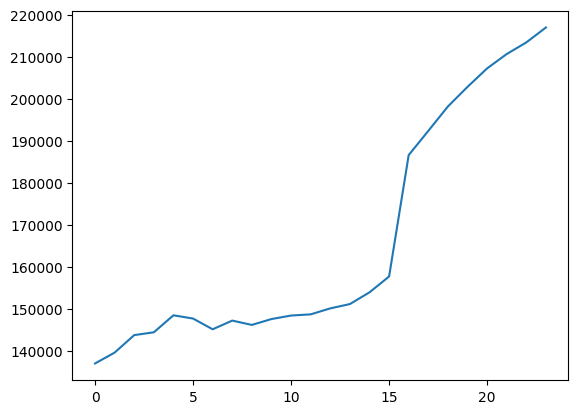

In [99]:
plt.plot(metro_enrollment['sum'])

In [100]:
# convert values
dataset = metro_enrollment['sum']
dataset = dataset.values
dataset = (dataset.astype('float32')).reshape(-1,1)
dataset

array([[137091.],
       [139677.],
       [143838.],
       [144501.],
       [148547.],
       [147775.],
       [145220.],
       [147288.],
       [146257.],
       [147656.],
       [148487.],
       [148770.],
       [150191.],
       [151218.],
       [154004.],
       [157766.],
       [186640.],
       [192390.],
       [198198.],
       [202861.],
       [207255.],
       [210668.],
       [213430.],
       [216982.]], dtype=float32)

In [101]:
# scale values so they are between 0 and 1 for LSTM model
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.        ],
       [0.03236914],
       [0.08445251],
       [0.09275138],
       [0.14339542],
       [0.1337322 ],
       [0.10175109],
       [0.12763643],
       [0.11473131],
       [0.13224268],
       [0.1426444 ],
       [0.14618671],
       [0.16397345],
       [0.17682838],
       [0.21170092],
       [0.25879014],
       [0.62020755],
       [0.69218063],
       [0.7648797 ],
       [0.8232467 ],
       [0.87824655],
       [0.92096734],
       [0.95553946],
       [1.        ]], dtype=float32)

In [102]:
# split into train and test set
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [103]:
# method to create sequence of lagged values for each enrollment count
def to_sequence(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset) - seq_size-1):
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
    
    return np.array(x), np.array(y)

In [104]:
# apply sequencing function
seq_size = 3
trainX, trainY = to_sequence(train, seq_size)
testX, testY = to_sequence(test, seq_size)

In [105]:
trainX.shape

(11, 3)

In [106]:
# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [107]:
# single LSTM with hidden layer
model = Sequential()
model.add(LSTM(64, input_shape=(None, seq_size)))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
print('Training')

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                17408     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 19521 (76.25 KB)
Trainable params: 19521 (76.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training


In [108]:
# fit model
model.fit(trainX, trainY, validation_data=(testX, testY), verbose=2, epochs=100)

Epoch 1/100
1/1 - 3s - loss: 0.0199 - val_loss: 0.7774 - 3s/epoch - 3s/step
Epoch 2/100
1/1 - 0s - loss: 0.0172 - val_loss: 0.7403 - 48ms/epoch - 48ms/step
Epoch 3/100
1/1 - 0s - loss: 0.0146 - val_loss: 0.7043 - 51ms/epoch - 51ms/step
Epoch 4/100
1/1 - 0s - loss: 0.0123 - val_loss: 0.6695 - 39ms/epoch - 39ms/step
Epoch 5/100
1/1 - 0s - loss: 0.0102 - val_loss: 0.6357 - 36ms/epoch - 36ms/step
Epoch 6/100
1/1 - 0s - loss: 0.0083 - val_loss: 0.6030 - 36ms/epoch - 36ms/step
Epoch 7/100
1/1 - 0s - loss: 0.0066 - val_loss: 0.5713 - 38ms/epoch - 38ms/step
Epoch 8/100
1/1 - 0s - loss: 0.0051 - val_loss: 0.5407 - 32ms/epoch - 32ms/step
Epoch 9/100
1/1 - 0s - loss: 0.0038 - val_loss: 0.5112 - 32ms/epoch - 32ms/step
Epoch 10/100
1/1 - 0s - loss: 0.0028 - val_loss: 0.4829 - 48ms/epoch - 48ms/step
Epoch 11/100
1/1 - 0s - loss: 0.0019 - val_loss: 0.4559 - 48ms/epoch - 48ms/step
Epoch 12/100
1/1 - 0s - loss: 0.0013 - val_loss: 0.4302 - 44ms/epoch - 44ms/step
Epoch 13/100
1/1 - 0s - loss: 8.1849e-04 

In [109]:
# make predictions
trainPreds = model.predict(trainX)
testPreds = model.predict(testX)

1/1 [==============================] - 0s 20ms/step


In [110]:
# invert predictions back to original scale
trainPreds = scaler.inverse_transform(trainPreds)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPreds)
testY = scaler.inverse_transform([testY])

In [111]:
# calculate mse
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPreds[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPreds[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1603.50 RMSE
Test Score: 206553.84 RMSE


In [118]:
# convert train and test predictions so it is in correct format for plotting
trainPredPlot = np.empty_like(dataset)
trainPredPlot[:, :] = np.nan
trainPredPlot[seq_size:len(trainPreds)+seq_size, :] = trainPreds
print(trainPredPlot)

testPredPlot = np.empty_like(dataset)
testPredPlot[:, :] = np.nan
testPredPlot[seq_size:len(testPreds)+seq_size, :] = testPreds
print(testPredPlot)

[[      nan]
 [      nan]
 [      nan]
 [146371.42]
 [146891.02]
 [147784.42]
 [147939.38]
 [148151.64]
 [148160.9 ]
 [147837.03]
 [148175.39]
 [148181.86]
 [148404.73]
 [148646.95]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]
 [      nan]]
[[       nan]
 [       nan]
 [       nan]
 [0.2274024 ]
 [0.28086665]
 [0.29818335]
 [0.31469756]
 [0.32814038]
 [       nan]
 [       nan]
 [       nan]
 [       nan]
 [       nan]
 [       nan]
 [       nan]
 [       nan]
 [       nan]
 [       nan]
 [       nan]
 [       nan]
 [       nan]
 [       nan]
 [       nan]
 [       nan]]


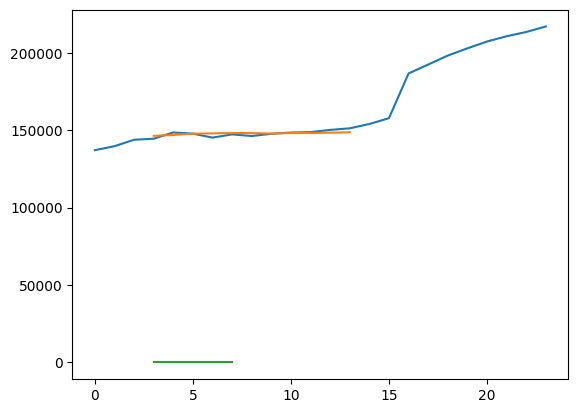

In [119]:
# plot the output
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredPlot)
plt.plot(testPredPlot)
plt.show()